In [130]:
import requests
import json
import matplotlib.pyplot as plt
import imageio.v2 as imageio

In [131]:

#   Desativando alguns warnings que o Kernel
#   do Python pode acionar devido à VPN
from requests.packages import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [132]:
'''
Esta classe requer os parâmetros 'url' indicando o endereço da API
e o parâmetro 'filename' sendo o nome do arquivo JSON
que vai ser gerado com a requisição feita através da API
'''

class RickAndMortyAPI():

    #   Construtor para instanciar objetos da classe
    def __init__(self, url, filename):

        self.characters: list = []  # lista de dicionários contendo personagens
        self.url: str = url
        self.filename: str = filename

    #   Retornar uma lista com todos os personagens da API
    def __getAPI(self, count):

        try:
            characters = []
            next_url = self.url
            while next_url and count > 0:

                rq_next = requests.get(next_url, verify=False)
                data_next = json.loads(rq_next.content)
                next_url = data_next['info']['next']

                for i in range(len(data_next['results'])):

                    #   Retirando as chaves que não pretendo utilizar
                    del data_next['results'][i]['episode']
                    del data_next['results'][i]['created']
                    del data_next['results'][i]['location']
                    del data_next['results'][i]['type']
                    del data_next['results'][i]['url']

                characters += data_next['results']
                count -= 20

            return characters

        except Exception as e:
            print(f"Erro na requisição da API:\n{e}")

    #   Armazenando os personagens no atributo da classe
    def getCharacters(self, count):
        
        self.characters = self.__getAPI(count)

    #   Método de escrita dos personagens em um arquivo JSON
    def writeFile(self):
        try:

            j = json.dumps(self.characters, indent=4, separators=(',', ':'))
            with open(f"{self.filename}", "w") as outfile:
                outfile.write(j)

        except Exception as e:
            print(f"Erro na escrita do arquivo:\n{e}")


In [133]:
'''
Essa classe trabalha com os valores retornados da API
e faz algumas manipulações de: busca, inserção, atualização e remoção
'''
class Characters():

    #   Construtor
    def __init__(self):

        self.char: list = [] #  lista de personagens (dicionários)

    #   Leitura do arquivo JSON com os personagens retornados da API
    def readFile(self, filename):

        try:
            with open(filename, 'r') as openfile:
                json_object = json.load(openfile)
            self.char = json_object

        except Exception as e:
            print(f"Erro na leitura do arquivo {filename}:\n{e}")

    #   Verifica se existe um personagem com base no ID
    def __isin(self, id):
        
        try:
            for i in range(len(self.char)):
                if id == self.char[i]["id"]:
                    return i #Retorna a posição com base no ID
            return False

        except Exception as e:
            print(f"Erro no personagem de ID = {id}:\n{e}")

    #   Esta função é para mostrar os personagens e 
    #   algumas informações relevantes sobre ele,
    #   possui um limite de até 3 personagens por pesquisa
    #   para facilitar a formatação dos dados
    def show_character(self, l: list):

        try:

            max_char = 3 #Máximo de personagens a serem printados
            fig = plt.figure()
            columns = len(l)

            if columns > max_char:
                columns = max_char

            for i in range(columns):

                ax = fig.add_subplot(1, columns, i+1)
                character = self.char[self.__isin(l[i])]
                url_img = str(character['image'])
                img = imageio.imread(url_img)

                ax.axis('off')
                plt.title(
                    f'{character["name"]} [{character["id"]}]', fontsize=11)
                plt.imshow(img)
                ax.text(0.5, -0.1, character["origin"]['name'],
                        size=8, ha='center', transform=ax.transAxes)
                ax.text(0.5, -0.2, character["species"],
                        size=8,  ha='center', transform=ax.transAxes)
                ax.text(0.5, -0.3, character["status"],
                        size=8,  ha='center', transform=ax.transAxes)

                plt.tight_layout()

        except Exception as e:
            print(f"Erro ao mostrar os personagens com ID = {l}:\n{e}")

    #   Esta função é para buscar as informações de um
    #   personagem com base no seu nome
    def search_character(self, substring):

        char_found = []
        count = 0

        try:
            for i in range(len(self.char)):

                if substring != None and len(substring) > 0 and \
                        substring.lower() in self.char[i]["name"].lower():
                    count += 1
                    char_found.append(self.char[i]["id"])

            #   Se houver o personagem, printar suas informações
            #   com a função anterior
            if not count:
                print("Personagem não encontrado.")
            else:
                self.show_character(char_found)

        except Exception as e:
            print(f"Erro na busca do personagem {substring}:\n{e}")

    #   Método de inserção de personagem
    def insert_character(self, name, status, species, gender, origin_name, origin_link, image_url):

        id = self.char[-1]['id'] + 1
        new_char = {

            "id": id,
            "name": name,
            "status": status,
            "species": species,
            "gender": gender,
            "origin": {
                "name": origin_name,
                "url": origin_link
            },
            "image": image_url
        }
        #   Decidi fazer uma verificação básica em relação ao nome
        #   apesar da API retornar personagens com o mesmo nome
        #   acredito que seja necessária uma diversidade

        try:

            for i in range(len(self.char)):
                if new_char["name"] == self.char[i]["name"]:
                    print(f"{new_char['name']} já está inserido.")
                    return

            self.char.append(new_char)
            print(f"{new_char['name']} inserido com sucesso.")

        except Exception as e:
            print(f"Erro na inserção do personagem:\n{e}")

    #   Método para excluir personagem
    def delete_character(self, id):

        try:

            i = self.__isin(id)
            if i:
                nome = self.char[i]['name']
                del self.char[i]
                print(f'{nome} deletado com sucesso!')
            else:
                print("Personagem não encontrado.")

        except Exception as e:
            print(f"Erro ao deletar personagem com ID = {id}:\n{e}")

    #   Método para atualizar as informações de um personagem
    def update_character(self, id, key, value):

        try:

            i = self.__isin(id)
            if i != None and key != 'id':
                self.char[i][key] = value
                print(f'{value} atualizado com sucesso.')
            elif key == 'id':
                print("Não é permitido alterar o ID do personagem.")
            else:
                print("Personagem não encontrado.")

        except Exception as e:
            print(f"Erro ao atualizar parâmetro {key} do personagem de ID = {id}:\n{e}")

    def all_character(self):

        try:
            for i in range(len(self.char)):
                print(f'{self.char[i]["name"]} [{self.char[i]["id"]}]')
        
        except Exception as e:
            print(f"Erro ao mostrar todos os personagems:\n{e}")


In [134]:
n_characters = 300 #    Número de personagens a retornar da API
url = "https://rickandmortyapi.com/api/character"
filename = "personagens.json"
api = RickAndMortyAPI(url, filename) #  Instanciando o objeto da classe
api.getCharacters(n_characters)
api.writeFile()

In [135]:
#   Instanciando o objeto e lendo o arquivo JSON
#   com os personagens da API
obj = Characters()
obj.readFile(filename)

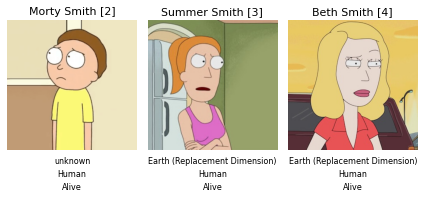

In [136]:
#   Pesquisando por nome
obj.search_character("Smith")

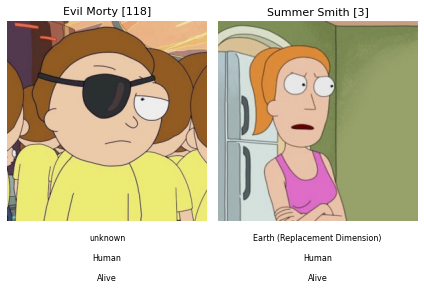

In [137]:
#   Também é possível mostrar os personagens
#   passando uma lista com os IDs
obj.show_character([118, 3])

In [138]:
#   Criando um personagem
nome = "Feirão Limpa Nome"
status = "Vivíssimo da Silva"
especie = "Vassoura"
genero = "Male"
nome_origem = "Serasa Experian"
url_origem = "https://www.serasaexperian.com.br/"
end_imagem = "serasa.png"

In [139]:
#   Inserindo o personagem
obj.insert_character(nome, status, especie, genero, nome_origem, url_origem, end_imagem)

Feirão Limpa Nome inserido com sucesso.


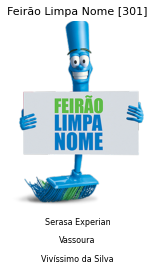

In [140]:
#   Pesquisando o personagem pelo nome
obj.search_character("feir")

In [141]:
#   Deletando o personagem por ID
obj.delete_character(301)

Feirão Limpa Nome deletado com sucesso!


In [142]:
#   Validando a exclusão do personagem
obj.search_character("fei")

Personagem não encontrado.


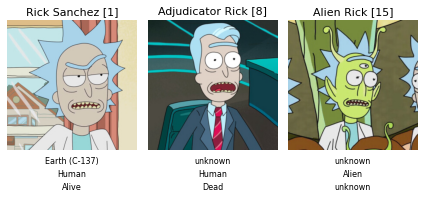

In [143]:
#   Printando alguns personagens
obj.search_character("Rick")

In [144]:
#   Escolhi um deles para alterar por ID e parâmetros
#   o primerio é o ID, o segundo é o atributo a ser mudado
#   e o terceiro é o novo valor desse atributo
obj.update_character(1,'name', 'O Rick mais Rick')

O Rick mais Rick atualizado com sucesso.


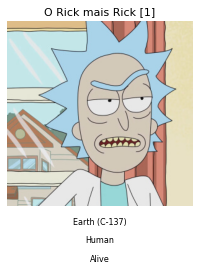

In [145]:
#   Validando as alterações no personagem
obj.search_character("Rick m")

In [146]:
#   Testando possíveis erros, como pesquisar por um float
obj.search_character(137.05)

Erro na busca do personagem 137.05:
object of type 'float' has no len()
